In [2]:
# Import libraries
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_regression

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime

In [5]:
# Read in data
df = pd.read_csv(r"C:\Users\Desktop\Tables\rt_10122020.csv")

# Filter to AK
AK_df = df[df['region'] == 'AK']
AK_df

,date,region,index,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests,new_tests,new_cases,new_deaths
11152,3/3/2020,AK,0,1.216957,1.199630,0.995083,1.397373,35.104083,0.000000,0.000000,0,0,NaN,NaN,NaN
11153,3/4/2020,AK,1,1.213711,1.202301,1.038286,1.421569,0.302331,0.000000,0.000000,0,0,NaN,NaN,NaN
11154,3/5/2020,AK,2,1.210970,1.205081,0.987535,1.367010,4.285902,0.000000,0.000000,0,0,NaN,NaN,NaN
11155,3/6/2020,AK,3,1.205701,1.197510,0.995439,1.364347,8.122132,0.000000,0.000000,0,0,0.0,0.0,0.0
11156,3/7/2020,AK,4,1.200403,1.189988,1.000990,1.353506,8.661355,0.000000,0.000000,0,0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11370,10/7/2020,AK,218,1.227448,1.212965,0.970022,1.462883,196.774067,154.082740,90.893432,274,10700,10700.0,274.0,1.0
11371,10/8/2020,AK,219,1.226616,1.210156,0.985525,1.479087,206.493481,160.029072,186.997419,135,1097,1097.0,135.0,1.0
11372,10/9/2020,AK,220,1.228154,1.211311,0.962793,1.469707,216.961559,166.340949,249.329892,180,1899,1899.0,180.0,0.0
11373,10/10/2020,AK,221,1.230522,1.216818,0.978304,1.502791,228.223058,173.043499,144.666179,252,6183,6183.0,252.0,0.0


# Data Exploration

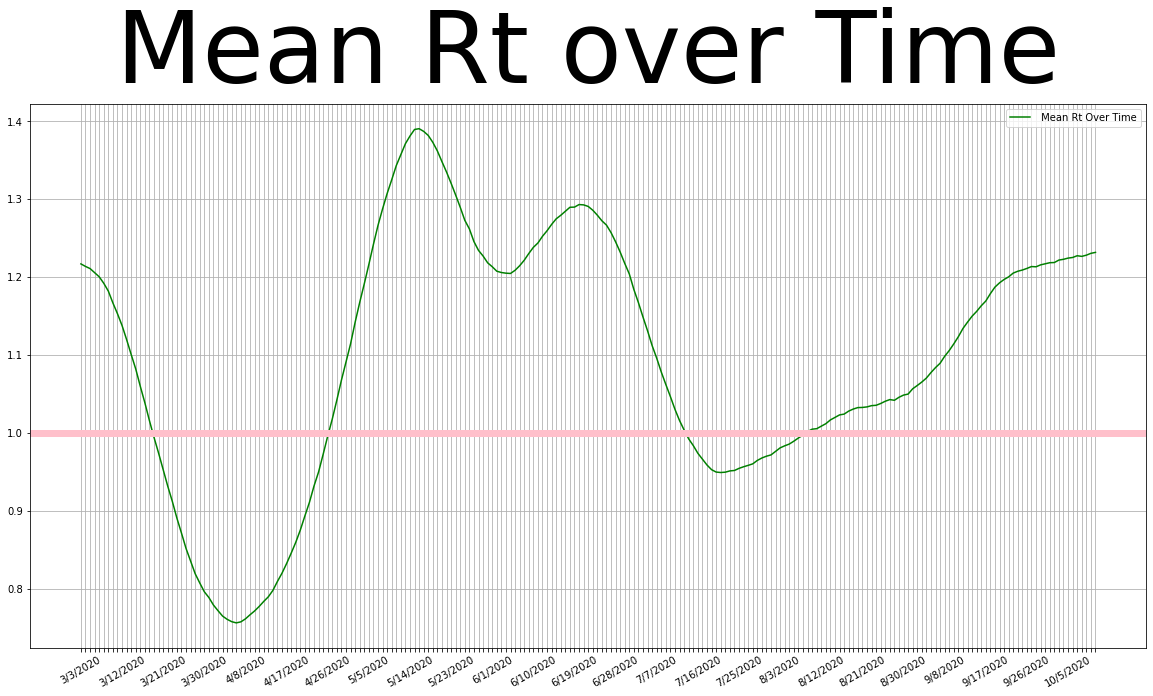

In [6]:
# Plot mean Rt over time

fig, ax = plt.subplots(figsize=(20, 10))


plt.plot(AK_df['date'], AK_df['mean'], color='green')

plt.xticks(rotation=30)
plt.legend([" Mean Rt Over Time"])
ax.set_title('Mean Rt over Time', fontsize=100)

# Draw line at Rt =1.0
plt.axhline(y=1.0, color='pink', linestyle='-', linewidth=7)

n = 9  # Keeps every nth label
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

plt.grid()
plt.show()




In [7]:
# Define vertical context function (mono-directional temporal contextualization)

def createVerticalContext(dfIn, varlist, size = 14):
    '''
    Function that creates a new variable that represents a certain amount of vertical context above and below the sample to be evaluated
    
    Inputs:
        dfIn - pandas dataframe, must contain columns passed with varlist
        varlist - list of column names that are desired for the vertical context
        size - integer, how many samples above and below the evaluation point to create context for
        
    Returns:
        dfOut - pandas dataframe with new columns appended
        'plus' = past
        'minus = future'
        
    @author:  Christopher Olsen    
    '''
    # perform check if variables are all in frame
    if len(varlist) != len(set(dfIn.columns).intersection(set(varlist))):
        print('One or more list variables is missing from the input dataframe.')
        return None
    lagdf = []
    
    for w in dfIn.region.unique():
        df_subset = dfIn[dfIn.region==w]
        for var in varlist:
            for i in range(size):
                df_subset[var + '_past' + str(i+1)] = df_subset[var].shift(i+1)
            for i in range(size):
                df_subset[var + '_future' + str(i+1)] = df_subset[var].shift(-1*(i+1))
        
        lagdf.append(df_subset)
    dfOut = pd.concat(lagdf)
    return dfOut

In [8]:
# Create field for time differenceing of mean Rt

AK_df = createVerticalContext(AK_df, ['mean'], size = 1)


# drop na's
AK_df.dropna(inplace=True)

# Add in 'daily spread' column 
AK_df['daily_change'] = AK_df['mean'] - AK_df['mean_past1']

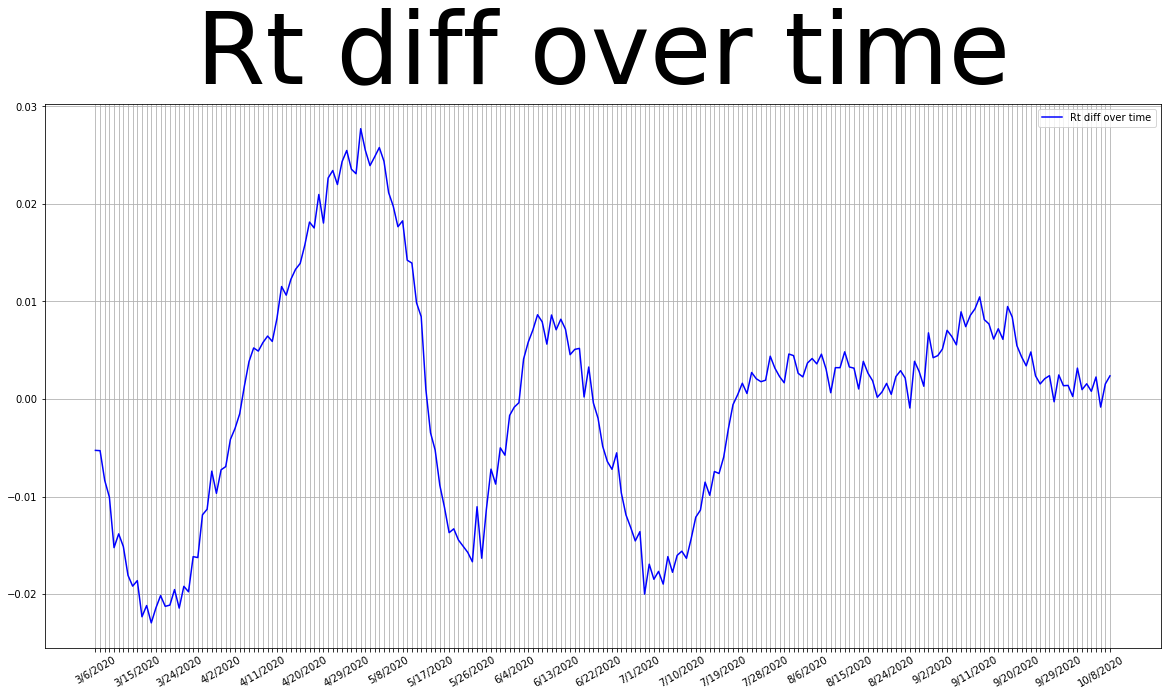

In [10]:
# Plot mean Rt difference

fig, ax = plt.subplots(figsize=(20, 10))


plt.plot(AK_df['date'], AK_df['daily_change'], color='blue')

plt.xticks(rotation=30)
plt.legend(["Rt diff over time"])
ax.set_title('Rt diff over time', fontsize=100)

n = 9  # Keeps every nth label
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

plt.grid()
plt.show()

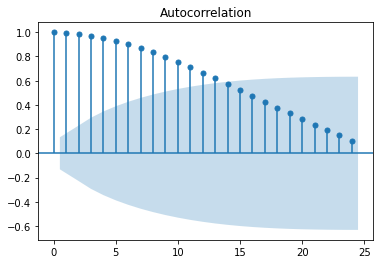

In [11]:
# Plot autocorrelation

from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot

plot_acf(AK_df['mean'])
pyplot.show()

C:\Users\wagneaj\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


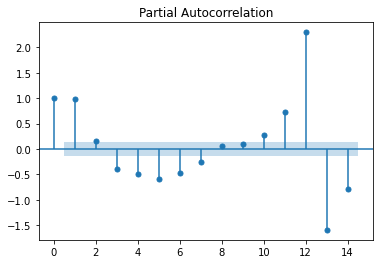

In [12]:
# Plot partial autocorrelation

from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(AK_df['daily_change'], lags=14)
pyplot.show()

# Prepare Data

In [21]:
# Create features

# Create field for time differenceing of mean Rt

features_prep = createVerticalContext(AK_df_init, ['mean', 'test_adjusted_positive'], size = 14)

# Add in differeced columns 
features_prep['daily_change'] = features_prep['mean'] - features_prep['mean_past1']
features_prep['day14_change'] = -1*(features_prep['mean_future14'] - features_prep['mean'])
features_prep.head(50)

,date,region,index,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,...,test_adjusted_positive_future7,test_adjusted_positive_future8,test_adjusted_positive_future9,test_adjusted_positive_future10,test_adjusted_positive_future11,test_adjusted_positive_future12,test_adjusted_positive_future13,test_adjusted_positive_future14,daily_change,day14_change
11152,3/3/2020,AK,0,1.216957,1.199630,0.995083,1.397373,35.104083,0.000000,0.000000,...,4.368279,5.248816,5.920790,6.764509,7.333596,8.187306,8.500305,8.926358,NaN,0.178550
11153,3/4/2020,AK,1,1.213711,1.202301,1.038286,1.421569,0.302331,0.000000,0.000000,...,5.248816,5.920790,6.764509,7.333596,8.187306,8.500305,8.926358,9.537446,-0.003246,0.198256
11154,3/5/2020,AK,2,1.210970,1.205081,0.987535,1.367010,4.285902,0.000000,0.000000,...,5.920790,6.764509,7.333596,8.187306,8.500305,8.926358,9.537446,9.834240,-0.002740,0.216931
11155,3/6/2020,AK,3,1.205701,1.197510,0.995439,1.364347,8.122132,0.000000,0.000000,...,6.764509,7.333596,8.187306,8.500305,8.926358,9.537446,9.834240,10.240116,-0.005269,0.231821
11156,3/7/2020,AK,4,1.200403,1.189988,1.000990,1.353506,8.661355,0.000000,0.000000,...,7.333596,8.187306,8.500305,8.926358,9.537446,9.834240,10.240116,10.595976,-0.005298,0.247779
11157,3/8/2020,AK,5,1.192052,1.183037,1.000021,1.343024,8.438869,0.000000,0.000000,...,8.187306,8.500305,8.926358,9.537446,9.834240,10.240116,10.595976,11.089734,-0.008351,0.260560
11158,3/9/2020,AK,6,1.181988,1.175213,1.004513,1.336143,8.569465,2.813220,0.000000,...,8.500305,8.926358,9.537446,9.834240,10.240116,10.595976,11.089734,11.353113,-0.010064,0.270036
11159,3/10/2020,AK,7,1.166751,1.163974,1.018770,1.323484,8.885672,4.368279,0.000000,...,8.926358,9.537446,9.834240,10.240116,10.595976,11.089734,11.353113,11.638883,-0.015237,0.276236
11160,3/11/2020,AK,8,1.152924,1.146844,1.002576,1.302830,9.187198,5.248816,0.000000,...,9.537446,9.834240,10.240116,10.595976,11.089734,11.353113,11.638883,11.925325,-0.013827,0.281617
11161,3/12/2020,AK,9,1.137795,1.127091,1.009572,1.290468,9.452745,5.920790,0.000000,...,9.834240,10.240116,10.595976,11.089734,11.353113,11.638883,11.925325,12.191318,-0.015129,0.286252


In [15]:
# Define delete first & last rows functions

def delete_rows_first(dfIn):
 
    lagdf = []
    
    for w in dfIn.region.unique():
        df_subset = dfIn[dfIn.region==w]
        df_del = df_subset.iloc[14:]
               
            
        lagdf.append(df_del)
    dfOut = pd.concat(lagdf)
    return dfOut

# Define delete last rows function

def delete_rows_last(dfIn):
 
    lagdf = []
    
    for w in dfIn.region.unique():
        df_subset = dfIn[dfIn.region==w]
        df_del = df_subset.iloc[:-14]
               
            
        lagdf.append(df_del)
    dfOut = pd.concat(lagdf)
    return dfOut


In [22]:
# Apply delete_rows_first function and delete_rows_last function

firstDelete = delete_rows_first(features_prep)
lastDelete = delete_rows_last(firstDelete)
features = lastDelete

In [23]:
# Define features

input = features
X = input.loc[:,['date','mean','daily_change', 'test_adjusted_positive' ,'test_adjusted_positive_past1', 'day14_change']]
y = input.loc[:,[ 'mean_future14']]

In [24]:
# Test, train, transform

from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, scale


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False) 


# Compile and evaluate naive model

In [25]:
# Prep data frame for naive model

naive_X = X[['date','mean', 'daily_change', 'day14_change']] 
naive_X.reset_index(drop=True)
naive_y = y
naive_y.reset_index(drop=True)

naive_df = pd.concat([naive_X, naive_y], axis=1)

In [26]:
# Define function for naive prediciton

def naive_pred(obs, med, sign_col):
    for i in sign_col:
        if i <= 0:
            naive_df['prediction'] = obs - med
        else:
            naive_df['prediction'] = obs + med
    return naive_df['prediction']
            

In [27]:
# Compile naive results into data frame

med_param = abs(naive_df['day14_change'].median())

naive_pred(naive_df['mean'], med_param, naive_df['daily_change'])

11166    1.071677
11167    1.048726
11168    1.027309
11169    1.007151
11170    0.985894
           ...   
11356    1.238430
11357    1.240804
11358    1.242345
11359    1.244431
11360    1.246820
Name: prediction, Length: 195, dtype: float64

# Compile and evaluate manually-tuned XGB model

In [28]:
# Define MAPE funciton for evaluation

# MAPE evaluation
import numpy as np

def MAPE(test_labels, predictions): 
    errors = abs(test_labels - predictions)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    
    return accuracy


In [29]:
# Evaluate naive model

MAPE(naive_df['mean_future14'], naive_df['prediction'])

90.49856405604793

In [104]:
naive_df.to_csv(r"C:\Users\naive_df.csv")

In [30]:
naive_df['predicted_date'] = pd.DatetimeIndex(naive_df['date']) + pd.DateOffset(14)
naive_df['observed_date'] = pd.DatetimeIndex(naive_df['date'])

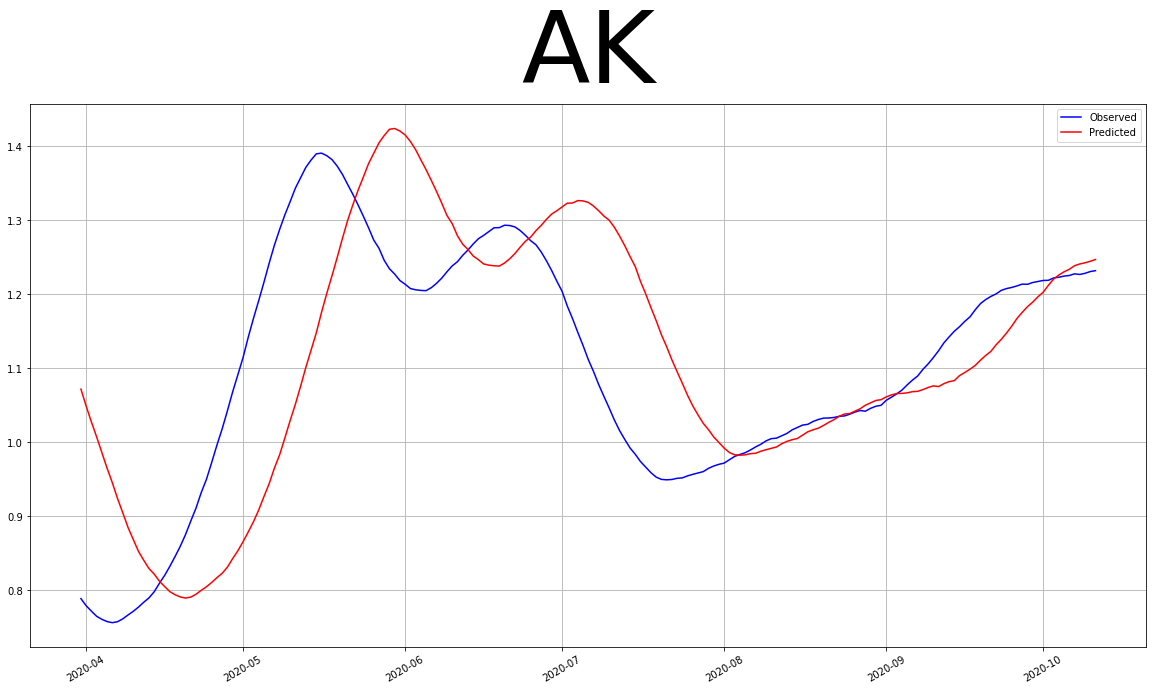

In [31]:
# observaton vs. predicton

fig, ax = plt.subplots(figsize=(20, 10))


plt.plot(naive_df['predicted_date'], naive_df['mean_future14'], color='blue')
plt.plot(naive_df['predicted_date'], naive_df['prediction'], color='red')
#plt.plot(naive_df['date'], naive_df['mean'], color='green')

plt.xticks(rotation=30)

plt.legend(["Observed", "Predicted"])


ax.set_title('AK', fontsize=100)

#n = 9  # Keeps every nth label
#[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

plt.grid()
plt.show()

In [33]:
input = features
X = input.loc[:,['mean','daily_change', 'test_adjusted_positive' ,'test_adjusted_positive_past1', 'day14_change']]
y = input.loc[:,[ 'mean_future14']]

In [34]:
# Test, train, transform

from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, scale


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False) 


In [35]:
# Run and score model

import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score

xgbr = xgb.XGBRegressor(verbosity=0, eval_metric='mae') 
model = xgbr.fit(X_train, y_train)

score =xgbr.score(X_train, y_train)  
print("Training score: ", score)

Training score:  0.999381356872282


In [37]:
predicted = pd.DataFrame(model.predict(X_test))

observed  = pd.DataFrame(y_test, columns=['mean_future14'])

predicted = pd.DataFrame(predicted, columns=[0])

observed.reset_index(drop=True, inplace=True)
predicted.reset_index(drop=True, inplace=True)

compare = pd.concat([observed, predicted], axis=1)

# Compile and evaluate XGB model with hyperparameter optimization

In [38]:
# Define features

input = features
X = input.loc[:,['mean','daily_change', 'test_adjusted_positive' ,'test_adjusted_positive_past1']]
y = input.loc[:,[ 'day14_change']]

In [39]:
# Test, train, transform

from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, scale


X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=False) 

In [40]:
# Convert features into matrices

import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [41]:
# Define default parameters

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}

params['eval_metric'] = "mae"

num_boost_round = 999

In [42]:
# Determine boosting rounds

boost_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best MAE: {:.2f} with {} rounds".format(
                 boost_model.best_score,
                 boost_model.best_iteration+1))

[09:57:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:0.356458
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:0.238729
[2]	Test-mae:0.147372
[3]	Test-mae:0.108533
[4]	Test-mae:0.0836
[5]	Test-mae:0.06172
[6]	Test-mae:0.051497
[7]	Test-mae:0.043597
[8]	Test-mae:0.041642
[9]	Test-mae:0.039329
[10]	Test-mae:0.039792
[11]	Test-mae:0.040095
[12]	Test-mae:0.03945
[13]	Test-mae:0.038127
[14]	Test-mae:0.038221
[15]	Test-mae:0.038832
[16]	Test-mae:0.037968
[17]	Test-mae:0.036853
[18]	Test-mae:0.036608
[19]	Test-mae:0.036306
[20]	Test-mae:0.036049
[21]	Test-mae:0.03595
[22]	Test-mae:0.035805
[23]	Test-mae:0.035764
[24]	Test-mae:0.035701
[25]	Test-mae:0.035703
[26]	Test-mae:0.03562
[27]	Test-mae:0.036284
[28]	Test-mae:0.036274
[29]	Test-mae:0.03692
[30]	Test-mae:0.036916
[31]	Test-mae:0.036908
[32]	Test-mae:0.03743
[33]	Test-mae:0.037437
[34]	Test-mae:0.

In [43]:
# Define MAPE funciton for evaluation

# MAPE evaluation
import numpy as np

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(100-(np.abs((y_true - y_pred) / y_true)) * 100)

In [44]:
# Tune hyperparameters

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results

# Return best parameters

cv_results['test-mae-mean'].min()

[09:57:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.025391199999999996

# Optimize Parameters

In [45]:
# Tune max_depth and min_child_weight

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1,10)
    for min_child_weight in range(1,10)
]

In [46]:
# Solve for optimal max_depth and min_child_weight parameters

min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=1, min_child_weight=1
[09:57:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.0323188 for 310 rounds
CV with max_depth=1, min_child_weight=2
[09:57:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/sr

	MAE 0.026478800000000004 for 88 rounds
CV with max_depth=2, min_child_weight=4
[09:57:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.026291600000000005 for 57 rounds
CV with max_depth=2, min_child_weight=5
[09:57:58] WARNING: 

	MAE 0.027027799999999998 for 47 rounds
CV with max_depth=3, min_child_weight=5
[09:57:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.0259536 for 30 rounds
CV with max_depth=3, min_child_weight=6
[09:57:59] WARNING: C:/Jenkins/

[09:58:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.024541399999999998 for 81 rounds
CV with max_depth=4, min_child_weight=7
[09:58:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:

	MAE 0.023899999999999998 for 79 rounds
CV with max_depth=5, min_child_weight=7
[09:58:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.024016 for 110 rounds
CV with max_depth=5, min_child_weight=8
[09:58:01] WARNING: C:/Jenkins/

	MAE 0.023639 for 96 rounds
CV with max_depth=6, min_child_weight=8
[09:58:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.0247154 for 138 rounds
CV with max_depth=6, min_child_weight=9
[09:58:03] WARNING: C:/Jenkins/workspace/x

	MAE 0.0237354 for 128 rounds
CV with max_depth=7, min_child_weight=9
[09:58:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.023868 for 84 rounds
CV with max_depth=8, min_child_weight=1
[09:58:04] WARNING: C:/Jenkins/workspace/x

	MAE 0.0248558 for 31 rounds
CV with max_depth=9, min_child_weight=2
[09:58:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.0223858 for 31 rounds
CV with max_depth=9, min_child_weight=3
[09:58:05] WARNING: C:/Jenkins/workspace/x

In [47]:
# Tune subsample and colsample_bytree

gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [48]:
# Solve for optimal subsample and colsample_bytree parameters


min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
[09:58:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.0240364 for 102 rounds
CV with subsample=1.0, colsample=0.9
[09:58:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/obje

	MAE 0.0236864 for 137 rounds
CV with subsample=0.8, colsample=0.8
[09:58:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.0236864 for 137 rounds
CV with subsample=0.8, colsample=0.7
[09:58:25] WARNING: C:/Jenkins/workspace/xgboo

In [49]:
# Solve for optimal ETA parameter

%time
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(params, dtrain,num_boost_round=num_boost_round,seed=42,nfold=5,metrics=['mae'],early_stopping_rounds=10)
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))





Wall time: 0 ns
CV with eta=0.3
[09:58:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 111 ms
	MAE 0.026740200000000002 for 73 rounds

CV with eta=0.2
[09:58:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/o

In [50]:
# Optimized parameters dictionary

params = {'colsample_bytree': 1.0,
 'eta': 0.1,
 'eval_metric': 'mae',
 'max_depth': 5,
 'min_child_weight': 3,
 'objective': 'reg:linear',
 'subsample': 0.9}

In [52]:
# Train model with optimized parameters

opt_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[09:59:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:0.500329
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:0.456752
[2]	Test-mae:0.410848
[3]	Test-mae:0.372663
[4]	Test-mae:0.336957
[5]	Test-mae:0.305797
[6]	Test-mae:0.268711
[7]	Test-mae:0.246603
[8]	Test-mae:0.217387
[9]	Test-mae:0.192097
[10]	Test-mae:0.171784
[11]	Test-mae:0.153476
[12]	Test-mae:0.136443
[13]	Test-mae:0.124036
[14]	Test-mae:0.112807
[15]	Test-mae:0.104566
[16]	Test-mae:0.097418
[17]	Test-mae:0.087079
[18]	Test-mae:0.081055
[19]	Test-mae:0.074439
[20]	Test-mae:0.069837
[21]	Test-mae:0.064192
[22]	Test-mae:0.060079
[23]	Test-mae:0.056601
[24]	Test-mae:0.052395
[25]	Test-mae:0.049492
[26]	Test-mae:0.046985
[27]	Test-mae:0.043462
[28]	Test-mae:0.041462
[29]	Test-mae:0.039504
[30]	Test-mae:0.037147
[31]	Test-mae:0.035115
[32]	Test-mae:0.034155
[33]	Test-mae:0.03322
[34]	Test

In [53]:
predict = pd.DataFrame(opt_model.predict(dtest))
MAPE(predict, y_test)

34.265752811525644